<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 161, '日付': '2021-10-03T08:00:00.000Z'},
 {'小計': 87, '日付': '2021-10-04T08:00:00.000Z'},
 {'小計': 144, '日付': '2021-10-05T08:00:00.000Z'},
 {'小計': 149, '日付': '2021-10-06T08:00:00.000Z'},
 {'小計': 143, '日付': '2021-10-07T08:00:00.000Z'},
 {'小計': 138, '日付': '2021-10-08T08:00:00.000Z'},
 {'小計': 82, '日付': '2021-10-09T08:00:00.000Z'},
 {'小計': 60, '日付': '2021-10-10T08:00:00.000Z'},
 {'小計': 49, '日付': '2021-10-11T08:00:00.000Z'},
 {'小計': 77, '日付': '2021-10-12T08:00:00.000Z'},
 {'小計': 72, '日付': '2021-10-13T08:00:00.000Z'},
 {'小計': 62, '日付': '2021-10-14T08:00:00.000Z'},
 {'小計': 57, '日付': '2021-10-15T08:00:00.000Z'},
 {'小計': 66, '日付': '2021-10-16T08:00:00.000Z'},
 {'小計': 40, '日付': '2021-10-17T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-10-13 17:00:00+09:00,129,0,72,2021-10-13 17:00:00+09:00
2021-10-14 17:00:00+09:00,100,0,62,2021-10-14 17:00:00+09:00
2021-10-15 17:00:00+09:00,0,0,57,2021-10-15 17:00:00+09:00
2021-10-16 17:00:00+09:00,0,0,66,2021-10-16 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-10-13 17:00:00+09:00,129,0,72,2021-10-13 17:00:00+09:00,141.142857,988.0,0.0,0.0,88.714286,621.0
2021-10-14 17:00:00+09:00,100,0,62,2021-10-14 17:00:00+09:00,133.142857,932.0,0.0,0.0,77.142857,540.0
2021-10-15 17:00:00+09:00,0,0,57,2021-10-15 17:00:00+09:00,117.428571,822.0,0.0,0.0,65.571429,459.0
2021-10-16 17:00:00+09:00,0,0,66,2021-10-16 17:00:00+09:00,96.000000,672.0,0.0,0.0,63.285714,443.0
2021-10-17 17:00:00+09:00,0,0,40,2021-10-17 17:00:00+09:00,78.000000,546.0,0.0,0.0,60.428571,423.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-10-03 17:00:00+09:00,126,0,161,2021-10-03 17:00:00+09:00,192.571429,1348.0,0.0,0.0,206.285714,1444.0,'21w39,Sun
2021-10-04 17:00:00+09:00,185,0,87,2021-10-04 17:00:00+09:00,187.285714,1311.0,0.0,0.0,196.714286,1377.0,'21w40,Mon
2021-10-05 17:00:00+09:00,163,0,144,2021-10-05 17:00:00+09:00,177.714286,1244.0,0.0,0.0,181.857143,1273.0,'21w40,Tue
2021-10-06 17:00:00+09:00,173,0,149,2021-10-06 17:00:00+09:00,172.571429,1208.0,0.0,0.0,165.000000,1155.0,'21w40,Wed
2021-10-07 17:00:00+09:00,156,0,143,2021-10-07 17:00:00+09:00,164.714286,1153.0,0.0,0.0,154.285714,1080.0,'21w40,Thu
2021-10-08 17:00:00+09:00,110,0,138,2021-10-08 17:00:00+09:00,156.857143,1098.0,0.0,0.0,145.428571,1018.0,'21w40,Fri
2021-10-09 17:00:00+09:00,150,0,82,2021-10-09 17:00:00+09:00,151.857143,1063.0,0.0,0.0,129.142857,904.0,'21w40,Sat
2021-10-10 17:00:00+09:00,126,0,60,2021-10-10 17:00:00+09:00,151.857143,1063.0,0.0,0.0,114.714286,803.0,'21w40,Sun
2021-10-11 17:00:00+09:00,154,0,49,2021-10-11 17:00:00+09:00,147.428571,1032.0,0.0,0.0,109.285714,765.0,'21w41,Mon
2021-10-12 17:00:00+09:00,163,0,77,2021-10-12 17:00:00+09:00,147.428571,1032.0,0.0,0.0,99.714286,698.0,'21w41,Tue


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-09-26 17:00:00+09:00,362.714286,2539
2021-10-03 17:00:00+09:00,206.285714,1444
2021-10-10 17:00:00+09:00,114.714286,803
2021-10-17 17:00:00+09:00,60.428571,423
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-10-03 17:00:00+09:00,126,0,161,2021-10-03 17:00:00+09:00,192.571429,1348.0,0.0,0.0,206.285714,1444.0,'21w39,Sun,206.285714,1444.0
2021-10-04 17:00:00+09:00,185,0,87,2021-10-04 17:00:00+09:00,187.285714,1311.0,0.0,0.0,196.714286,1377.0,'21w40,Mon,NaN,NaN
2021-10-05 17:00:00+09:00,163,0,144,2021-10-05 17:00:00+09:00,177.714286,1244.0,0.0,0.0,181.857143,1273.0,'21w40,Tue,NaN,NaN
2021-10-06 17:00:00+09:00,173,0,149,2021-10-06 17:00:00+09:00,172.571429,1208.0,0.0,0.0,165.000000,1155.0,'21w40,Wed,NaN,NaN
2021-10-07 17:00:00+09:00,156,0,143,2021-10-07 17:00:00+09:00,164.714286,1153.0,0.0,0.0,154.285714,1080.0,'21w40,Thu,NaN,NaN
2021-10-08 17:00:00+09:00,110,0,138,2021-10-08 17:00:00+09:00,156.857143,1098.0,0.0,0.0,145.428571,1018.0,'21w40,Fri,NaN,NaN
2021-10-09 17:00:00+09:00,150,0,82,2021-10-09 17:00:00+09:00,151.857143,1063.0,0.0,0.0,129.142857,904.0,'21w40,Sat,NaN,NaN
2021-10-10 17:00:00+09:00,126,0,60,2021-10-10 17:00:00+09:00,151.857143,1063.0,0.0,0.0,114.714286,803.0,'21w40,Sun,114.714286,803.0
2021-10-11 17:00:00+09:00,154,0,49,2021-10-11 17:00:00+09:00,147.428571,1032.0,0.0,0.0,109.285714,765.0,'21w41,Mon,NaN,NaN
2021-10-12 17:00:00+09:00,163,0,77,2021-10-12 17:00:00+09:00,147.428571,1032.0,0.0,0.0,99.714286,698.0,'21w41,Tue,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

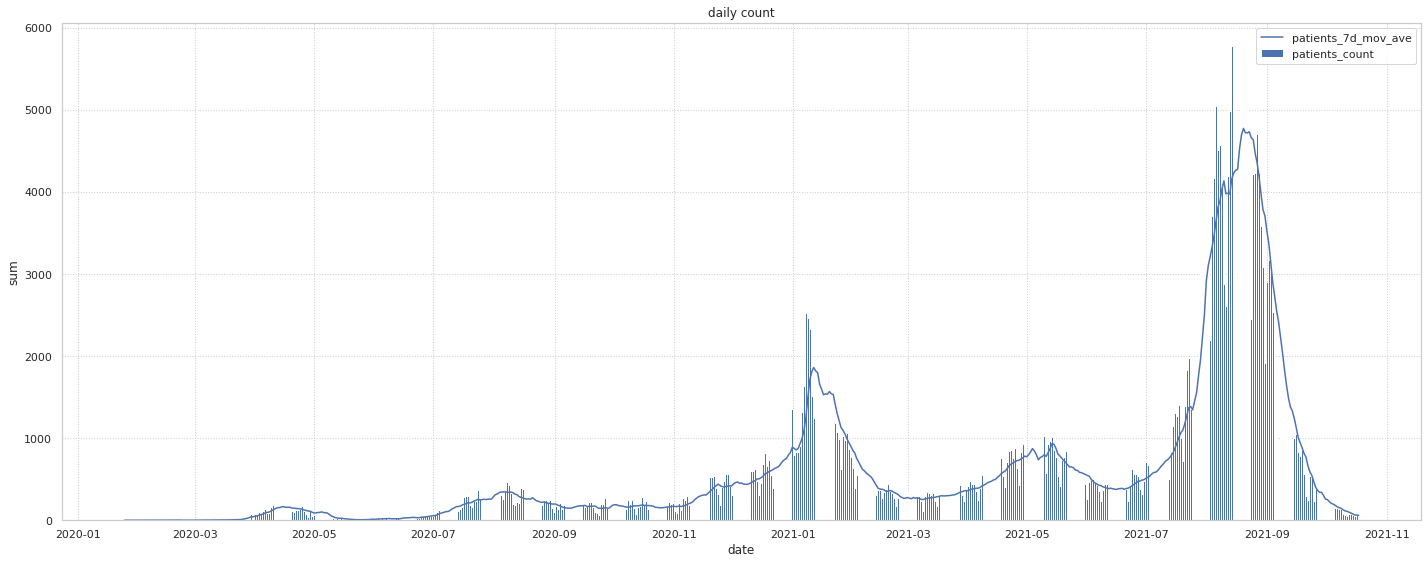

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
618,1.633248e+09,2021,10,3,0,0,0,1,0,0,0,618,0,544,126,192.571429,1348.0,0,0.0,0.0,161,206.285714,1444.0
619,1.633334e+09,2021,10,4,0,1,0,0,0,0,0,619,0,545,185,187.285714,1311.0,0,0.0,0.0,87,196.714286,1377.0
620,1.633421e+09,2021,10,5,0,0,0,0,0,1,0,620,0,546,163,177.714286,1244.0,0,0.0,0.0,144,181.857143,1273.0
621,1.633507e+09,2021,10,6,0,0,0,0,0,0,1,621,0,547,173,172.571429,1208.0,0,0.0,0.0,149,165.000000,1155.0
622,1.633594e+09,2021,10,7,0,0,0,0,1,0,0,622,0,548,156,164.714286,1153.0,0,0.0,0.0,143,154.285714,1080.0
623,1.633680e+09,2021,10,8,1,0,0,0,0,0,0,623,0,549,110,156.857143,1098.0,0,0.0,0.0,138,145.428571,1018.0
624,1.633766e+09,2021,10,9,0,0,1,0,0,0,0,624,0,550,150,151.857143,1063.0,0,0.0,0.0,82,129.142857,904.0
625,1.633853e+09,2021,10,10,0,0,0,1,0,0,0,625,0,551,126,151.857143,1063.0,0,0.0,0.0,60,114.714286,803.0
626,1.633939e+09,2021,10,11,0,1,0,0,0,0,0,626,0,552,154,147.428571,1032.0,0,0.0,0.0,49,109.285714,765.0
627,1.634026e+09,2021,10,12,0,0,0,0,0,1,0,627,0,553,163,147.428571,1032.0,0,0.0,0.0,77,99.714286,698.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633 entries, 0 to 632
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            633 non-null    float64
 1   year                 633 non-null    int64  
 2   month                633 non-null    int64  
 3   day                  633 non-null    int64  
 4   Fri                  633 non-null    uint8  
 5   Mon                  633 non-null    uint8  
 6   Sat                  633 non-null    uint8  
 7   Sun                  633 non-null    uint8  
 8   Thu                  633 non-null    uint8  
 9   Tue                  633 non-null    uint8  
 10  Wed                  633 non-null    uint8  
 11  passed               633 non-null    int64  
 12  emergency            633 non-null    int64  
 13  em_passed            633 non-null    int64  
 14  contacts_count       633 non-null    int64  
 15  contacts_7d_mov_ave  633 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,6.330000e+02,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000,633.000000
mean,1.607155e+09,2020.458136,6.162717,15.679305,0.143760,0.142180,0.143760,0.143760,0.142180,0.142180,0.142180,316.000000,0.077409,246.383886,677.938389,677.776537,4744.429700,582.178515,582.178515,4075.249605,595.890995,595.622726,4169.333333
std,1.580046e+07,0.498638,3.135707,8.831214,0.351124,0.349511,0.351124,0.351124,0.349511,0.349511,0.349511,182.875641,0.267451,176.298087,466.507795,453.732733,3176.138144,829.671602,755.767850,5290.374947,968.300362,934.422291,6540.972460
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.593504e+09,2020.000000,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,158.000000,0.000000,84.000000,363.000000,367.428571,2572.000000,0.000000,0.000000,0.000000,98.000000,123.142857,862.000000
50%,1.607155e+09,2020.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,316.000000,0.000000,242.000000,519.000000,539.571429,3777.000000,0.000000,0.000000,0.000000,275.000000,287.142857,2010.000000
75%,1.620806e+09,2021.000000,9.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,474.000000,0.000000,400.000000,810.000000,815.428571,5708.000000,1201.000000,1191.000000,8337.000000,602.000000,616.142857,4313.000000
max,1.634458e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,632.000000,1.000000,558.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,5773.000000,4774.428571,33421.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.862986,0.271064,-0.013811,-0.002242,-0.003342,-1.328078e-18,0.002242,0.003342,-0.001114,0.001114,1.000000e+00,-0.345570,0.997587,-0.145970,-0.126158,-0.126154,-0.602615,-0.648886,-0.648886,0.530409,0.559602,0.559608
year,8.629855e-01,1.000000,-0.250143,-0.040602,0.002798,-0.002108,2.798270e-03,0.002798,-0.002108,-0.002108,-0.002108,8.629855e-01,-0.266344,0.872300,-0.166698,-0.146468,-0.146466,-0.645721,-0.708864,-0.708864,0.472157,0.498775,0.498778
month,2.710635e-01,-0.250143,1.000000,-0.041366,-0.009783,-0.002374,-5.471430e-03,-0.001160,0.010619,0.001957,0.006288,2.710635e-01,-0.152772,0.248572,0.039389,0.038693,0.038696,0.076995,0.109888,0.109888,0.114141,0.119401,0.119407
day,-1.381126e-02,-0.040602,-0.041366,1.000000,0.001624,0.000442,1.114056e-03,0.001114,-0.002121,-0.000583,-0.001608,-1.381126e-02,0.000478,-0.013274,0.001059,0.000090,0.000087,0.012240,0.000615,0.000615,0.014552,0.011194,0.011190
Fri,-2.242376e-03,0.002798,-0.009783,0.001624,1.000000,-0.166818,-1.678967e-01,-0.167897,-0.166818,-0.166818,-0.166818,-2.242376e-03,-0.000745,-0.001558,-0.019217,-0.003701,-0.003700,0.027829,-0.001984,-0.001984,0.029472,-0.001593,-0.001596
Mon,-3.341951e-03,-0.002108,-0.002374,0.000442,-0.166818,1.000000,-1.668178e-01,-0.166818,-0.165746,-0.165746,-0.165746,-3.341951e-03,0.000562,-0.003429,0.038289,0.002486,0.002486,0.119083,0.001495,0.001495,-0.094760,0.001096,0.001097
Sat,-1.328078e-18,0.002798,-0.005471,0.001114,-0.167897,-0.166818,1.000000e+00,-0.167897,-0.166818,-0.166818,-0.166818,-1.925972e-18,-0.000745,0.000487,0.044846,-0.003701,-0.003700,-0.137070,-0.001984,-0.001984,0.030180,-0.001549,-0.001550
Sun,2.242376e-03,0.002798,-0.001160,0.001114,-0.167897,-0.166818,-1.678967e-01,1.000000,-0.166818,-0.166818,-0.166818,2.242376e-03,-0.000745,0.002532,-0.028278,-0.003701,-0.003700,-0.126429,-0.001984,-0.001984,-0.024159,-0.001523,-0.001523
Thu,3.341951e-03,-0.002108,0.010619,-0.002121,-0.166818,-0.165746,-1.668178e-01,-0.166818,1.000000,-0.165746,-0.165746,3.341951e-03,0.000562,0.002708,-0.004692,0.003044,0.003045,0.035707,0.001495,0.001495,0.055505,0.001241,0.001243
Tue,-1.113984e-03,-0.002108,0.001957,-0.000583,-0.166818,-0.165746,-1.668178e-01,-0.166818,-0.165746,1.000000,-0.165746,-1.113984e-03,0.000562,-0.001401,-0.019549,0.002718,0.002719,0.048328,0.001495,0.001495,-0.019366,0.001149,0.001150


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,1.634112e+09,0,0,0,0,0,0,1,628,0,554,129,0,72,88.714286,621.0
629,1.634198e+09,0,0,0,0,1,0,0,629,0,555,100,0,62,77.142857,540.0
630,1.634285e+09,1,0,0,0,0,0,0,630,0,556,0,0,57,65.571429,459.0
631,1.634371e+09,0,0,1,0,0,0,0,631,0,557,0,0,66,63.285714,443.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
628,1.634112e+09,628,0,72,88.714286,621.0
629,1.634198e+09,629,0,62,77.142857,540.0
630,1.634285e+09,630,0,57,65.571429,459.0
631,1.634371e+09,631,0,66,63.285714,443.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

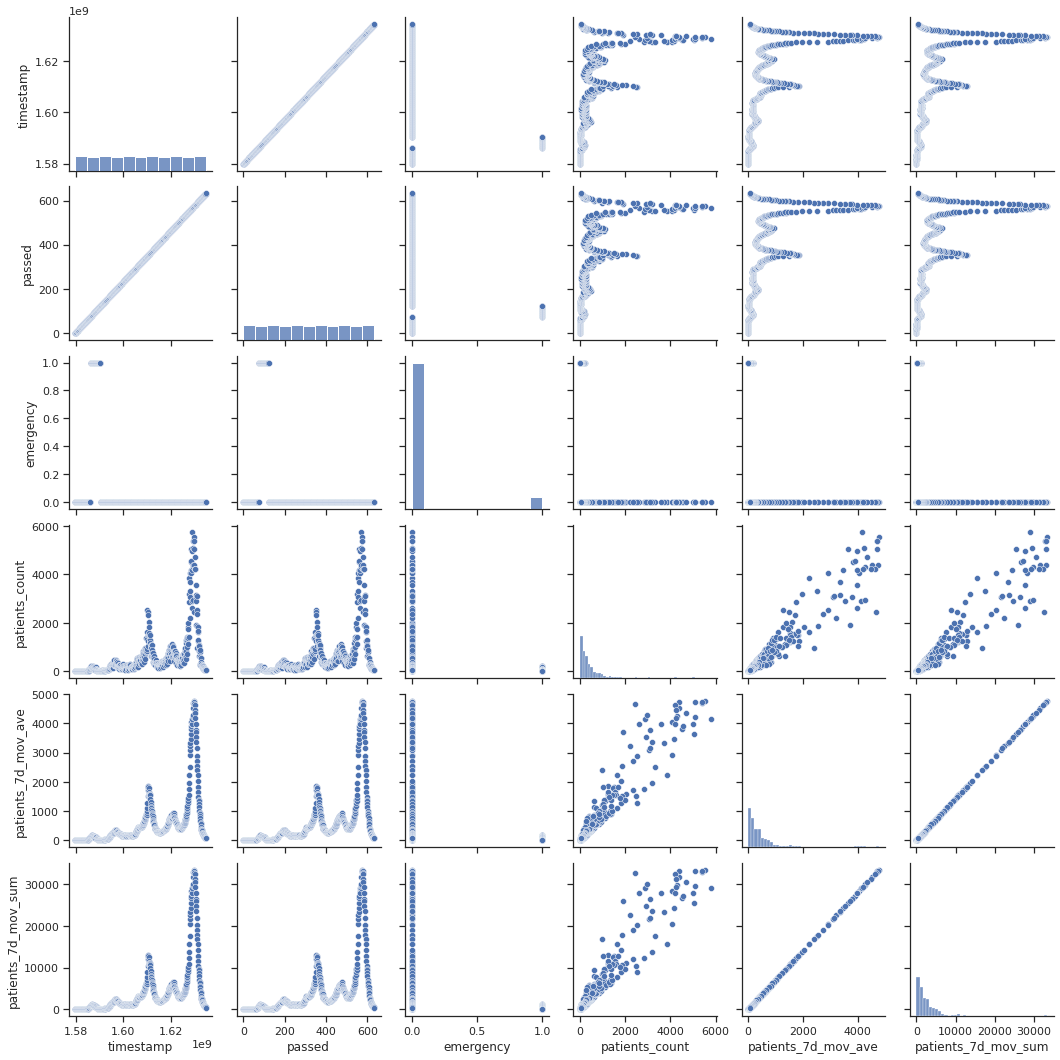

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.12
